<a href="https://colab.research.google.com/github/casalazara/Machine-Learning-IELE/blob/master/Reto2/Reto_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerías necesarias

In [1]:
import matplotlib.pyplot as plt
from sklearn import metrics 
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score,mean_squared_error


# Lectura de archivo

Al leer el archivo se retira la columna RISK_MM. Pues según la [página origen](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) de la base de datos está columna define la cantidad de lluvia en milímetros que cayó al día sugiente. Al ser información sobre el futuro, se debe retirar de forma que se pueda conseguir un modelo que sirva. Básicamente se dejarán todas las columnas pues consideramos que la fecha y la locación así como la dirección del viento y demás variables categóricas influyen drásticamente en el hecho de si lloverá o no al día siguiente, es decir, puede ser que en dos lugares se presenten casi las mismas condiciones climáticas pero quizá las condiciones geográficas de un lugar (altura o demás variables ausentes en el dataset) influyan en el hecho de que llueva al día siguiente o no.

In [2]:

df = pd.read_csv('https://raw.githubusercontent.com/casalazara/Machine-Learning-IELE/master/Reto2/weatherAUS.csv',parse_dates=["Date"])
print(df.shape)
df.drop(['RISK_MM'], axis=1, inplace=True)
df.head()

(142193, 24)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


# Manejo de las variables



## Tipos y valores faltantes
---
Podemos ver que las variables fueron cargadas correctamente de acuerdo a los valores presentes en las filas del dataframe, es decir no hubo variables numéricas cargadas como string ni de tipo Date como string o numéricas.
También podemos ver que algunas columnas cuentan con una gran cantidad de valores faltantes por lo que más adelante los trataremos.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           142193 non-null  datetime64[ns]
 1   Location       142193 non-null  object        
 2   MinTemp        141556 non-null  float64       
 3   MaxTemp        141871 non-null  float64       
 4   Rainfall       140787 non-null  float64       
 5   Evaporation    81350 non-null   float64       
 6   Sunshine       74377 non-null   float64       
 7   WindGustDir    132863 non-null  object        
 8   WindGustSpeed  132923 non-null  float64       
 9   WindDir9am     132180 non-null  object        
 10  WindDir3pm     138415 non-null  object        
 11  WindSpeed9am   140845 non-null  float64       
 12  WindSpeed3pm   139563 non-null  float64       
 13  Humidity9am    140419 non-null  float64       
 14  Humidity3pm    138583 non-null  float64       
 15  

## Cardinalidad de las variables
---
Podemos ver que afortunadamente la cardinalidad de las variables no numéricas es relativamente baja salvo la de la variable Date por lo que al ser de tipo datetime64 sería conveniente descomponerla.


In [4]:
for col in df.columns:
  print(f"Cardinalidad de la columna {col}: {len(df[col].unique())}")
  print(df[col].value_counts())

Cardinalidad de la columna Date: 3436
2013-12-22    49
2014-02-27    49
2016-08-21    49
2013-07-02    49
2017-05-05    49
              ..
2007-11-14     1
2007-11-23     1
2007-11-13     1
2007-12-30     1
2007-12-28     1
Name: Date, Length: 3436, dtype: int64
Cardinalidad de la columna Location: 49
Canberra            3418
Sydney              3337
Perth               3193
Darwin              3192
Hobart              3188
Brisbane            3161
Adelaide            3090
Bendigo             3034
Townsville          3033
AliceSprings        3031
MountGambier        3030
Ballarat            3028
Launceston          3028
Albany              3016
Albury              3011
MelbourneAirport    3009
PerthAirport        3009
Mildura             3007
SydneyAirport       3005
Nuriootpa           3002
Sale                3000
Watsonia            2999
Tuggeranong         2998
Portland            2996
Woomera             2990
Cairns              2988
Cobar               2988
Wollongong          2

## Descomposición variable Date
---
La variable Date será descompuesta en día mes y año pues primero permite a partir de una variable con cardinalidad alta obtener 3 variables de cardinalidad relativamente baja y segundo, para el modelo las variables deben ser numéricas.

In [5]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop(columns="Date",inplace=True)
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,2008,12,1
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,2008,12,2
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,2008,12,3
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,2008,12,4
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,2008,12,5


## Manejo de valores extremos
---
Para las variables numéricas se hará un análisis con ayuda de los percentiles para identificar estos valores extremos 

In [6]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Year,Month,Day
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000,142193.000000,142193.000000,142193.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235,2012.758926,6.402544,15.715084
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594,2.541256,3.426506,8.798150
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,2007.000000,1.000000,1.000000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,2011.000000,3.000000,8.000000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,2013.000000,6.000000,16.000000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,2015.000000,9.000000,23.000000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,2017.000000,12.000000,31.000000


Vemos que variables como _Rainfall_, _Evaporation_, _WindGustSpeed_, _WindSpeed9am_, _WindSpeed3pm_ y _RISK_MM_ cuentan con valores máximos bastante grandes. Sin embargo, no estamos del todo seguros de que sean realmente outliers por lo que los identificaremos con el rango interquantil y la regla [1.5xIQR](https://www.khanacademy.org/math/statistics-probability/summarizing-quantitative-data/box-whisker-plots/a/identifying-outliers-iqr-rule).

In [7]:
for columna in df.columns:
  if df[columna].dtype == "float64":
    Q1 = df[columna].quantile(.25)
    Q3 = df[columna].quantile(.75)
    IQR = Q3 - Q1
    inferior = Q1 - (IQR*1.5) 
    superior = Q3 + (IQR*1.5)
    print(f"Rango de los outliers para la columna {columna}: x<{inferior} o x>{superior}")

Rango de los outliers para la columna MinTemp: x<-6.200000000000001 o x>30.6
Rango de los outliers para la columna MaxTemp: x<2.4499999999999975 o x>43.65
Rango de los outliers para la columna Rainfall: x<-1.2000000000000002 o x>2.0
Rango de los outliers para la columna Evaporation: x<-4.600000000000001 o x>14.600000000000001
Rango de los outliers para la columna Sunshine: x<-3.6499999999999986 o x>19.15
Rango de los outliers para la columna WindGustSpeed: x<5.5 o x>73.5
Rango de los outliers para la columna WindSpeed9am: x<-11.0 o x>37.0
Rango de los outliers para la columna WindSpeed3pm: x<-3.5 o x>40.5
Rango de los outliers para la columna Humidity9am: x<18.0 o x>122.0
Rango de los outliers para la columna Humidity3pm: x<-6.5 o x>109.5
Rango de los outliers para la columna Pressure9am: x<998.65 o x>1036.65
Rango de los outliers para la columna Pressure3pm: x<996.0 o x>1034.4
Rango de los outliers para la columna Cloud9am: x<-8.0 o x>16.0
Rango de los outliers para la columna Cloud3p

En el análisis de los datos se pudo evidenciar que las variables Rainfall, Evaporation, WindSpeed9am y WindSpeed3pm tienen un máximo demasiado grande, por lo que se va a reemplazar estos valores por el "tope" definido por la regla 1.5*IQR.

In [8]:
def max_value(dfParam, variable, top):
    return np.where(dfParam[variable]>top, top, dfParam[variable])

df['Rainfall'] = max_value(df, 'Rainfall', 2.0)
df['Evaporation'] = max_value(df, 'Evaporation', 14.6)
df['WindSpeed9am'] = max_value(df, 'WindSpeed9am', 37.0)
df['WindSpeed3pm'] = max_value(df, 'WindSpeed3pm', 40.5)

df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Year,Month,Day
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000,142193.000000,142193.000000,142193.000000
mean,12.186400,23.226784,0.485723,5.321137,7.624853,39.984292,13.912024,18.549386,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235,2012.758926,6.402544,15.715084
std,6.403283,7.117618,0.791851,3.418304,3.781525,13.588801,8.591819,8.526274,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594,2.541256,3.426506,8.798150
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,2007.000000,1.000000,1.000000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,2011.000000,3.000000,8.000000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,2013.000000,6.000000,16.000000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,2015.000000,9.000000,23.000000
max,33.900000,48.100000,2.000000,14.600000,14.500000,135.000000,37.000000,40.500000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,2017.000000,12.000000,31.000000


## Manejo de valores vacíos
---
Se realizará un conteo de las filas con valores vacíos, y se reemplazarán con valores adecuados



Primero verificamos el porcentaje de valores faltantes en las columnas 

In [9]:
def completitud(df):
  mis_val = df.isnull().sum()
  mis_val_percent = 100 * (1 - (df.isnull().sum()/len(df)))
  mis_val_percent.rename_axis('Atributo',inplace=True)
  return mis_val_percent
completitud(df)

Atributo
Location         100.000000
MinTemp           99.552017
MaxTemp           99.773547
Rainfall          99.011203
Evaporation       57.210974
Sunshine          52.307076
WindGustDir       93.438496
WindGustSpeed     93.480692
WindDir9am        92.958162
WindDir3pm        97.343048
WindSpeed9am      99.051993
WindSpeed3pm      98.150401
Humidity9am       98.752400
Humidity3pm       97.461197
Pressure9am       90.144381
Pressure3pm       90.167589
Cloud9am          62.264668
Cloud3pm          59.847531
Temp9am           99.364244
Temp3pm           98.082887
RainToday         99.011203
RainTomorrow     100.000000
Year             100.000000
Month            100.000000
Day              100.000000
dtype: float64

Suponemos que los datos faltantes no siguen algún patrón especifico ni se sabe como tratarlos directamente. En este caso se pueden hacer 2 cosas, o rellenar las filas con datos aleatorios en las columnas faltantes, o rellenarlas con la mediana o media de los datos. 

Vamos a llenar los valores faltantes con las medidas estadísticas apropiadas de los datos, en este caso la mediana. La imputación se debe realizar sobre el conjunto de entrenamiento y luego propagarse al conjunto de prueba. Significa que las medidas estadísticas que se utilizarán para completar los valores faltantes tanto en el de entrenamiento como en el conjunto de prueba, deben extraerse únicamente del conjunto de entrenamiento. Esto es para evitar un ajuste excesivo.

In [10]:
for col in df.columns:
  if df[col].dtype == "float64":
    df[col].fillna(df[col].median(), inplace=True)       

Ahora verificamos el porcentaje de valores faltantes en las columnas categóricas

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       142193 non-null  object 
 1   MinTemp        142193 non-null  float64
 2   MaxTemp        142193 non-null  float64
 3   Rainfall       142193 non-null  float64
 4   Evaporation    142193 non-null  float64
 5   Sunshine       142193 non-null  float64
 6   WindGustDir    132863 non-null  object 
 7   WindGustSpeed  142193 non-null  float64
 8   WindDir9am     132180 non-null  object 
 9   WindDir3pm     138415 non-null  object 
 10  WindSpeed9am   142193 non-null  float64
 11  WindSpeed3pm   142193 non-null  float64
 12  Humidity9am    142193 non-null  float64
 13  Humidity3pm    142193 non-null  float64
 14  Pressure9am    142193 non-null  float64
 15  Pressure3pm    142193 non-null  float64
 16  Cloud9am       142193 non-null  float64
 17  Cloud3pm       142193 non-nul

Al todas las columnas que presentaron datos faltantes se les va a reemplazar con el valor más frecuente. Esto con el fin de afectar lo menos posible los datos y a su vez conservar la totalidad de los mismos.

In [12]:
for col in df.columns:
  if df[col].dtype != "float64" and col != 'Date':
    df[col].fillna(df[col].mode()[0], inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       142193 non-null  object 
 1   MinTemp        142193 non-null  float64
 2   MaxTemp        142193 non-null  float64
 3   Rainfall       142193 non-null  float64
 4   Evaporation    142193 non-null  float64
 5   Sunshine       142193 non-null  float64
 6   WindGustDir    142193 non-null  object 
 7   WindGustSpeed  142193 non-null  float64
 8   WindDir9am     142193 non-null  object 
 9   WindDir3pm     142193 non-null  object 
 10  WindSpeed9am   142193 non-null  float64
 11  WindSpeed3pm   142193 non-null  float64
 12  Humidity9am    142193 non-null  float64
 13  Humidity3pm    142193 non-null  float64
 14  Pressure9am    142193 non-null  float64
 15  Pressure3pm    142193 non-null  float64
 16  Cloud9am       142193 non-null  float64
 17  Cloud3pm       142193 non-nul

In [14]:
completitud(df)

Atributo
Location         100.0
MinTemp          100.0
MaxTemp          100.0
Rainfall         100.0
Evaporation      100.0
Sunshine         100.0
WindGustDir      100.0
WindGustSpeed    100.0
WindDir9am       100.0
WindDir3pm       100.0
WindSpeed9am     100.0
WindSpeed3pm     100.0
Humidity9am      100.0
Humidity3pm      100.0
Pressure9am      100.0
Pressure3pm      100.0
Cloud9am         100.0
Cloud3pm         100.0
Temp9am          100.0
Temp3pm          100.0
RainToday        100.0
RainTomorrow     100.0
Year             100.0
Month            100.0
Day              100.0
dtype: float64

## Distribución de las variables numéricas
---
Dado que las variables numéricas parecen ser continuas se graficará un histograma para cada variable de manera que se pueda identificar la distribución que siguen y establecer el tipo de normalización a realizar.



In [15]:
%matplotlib inline

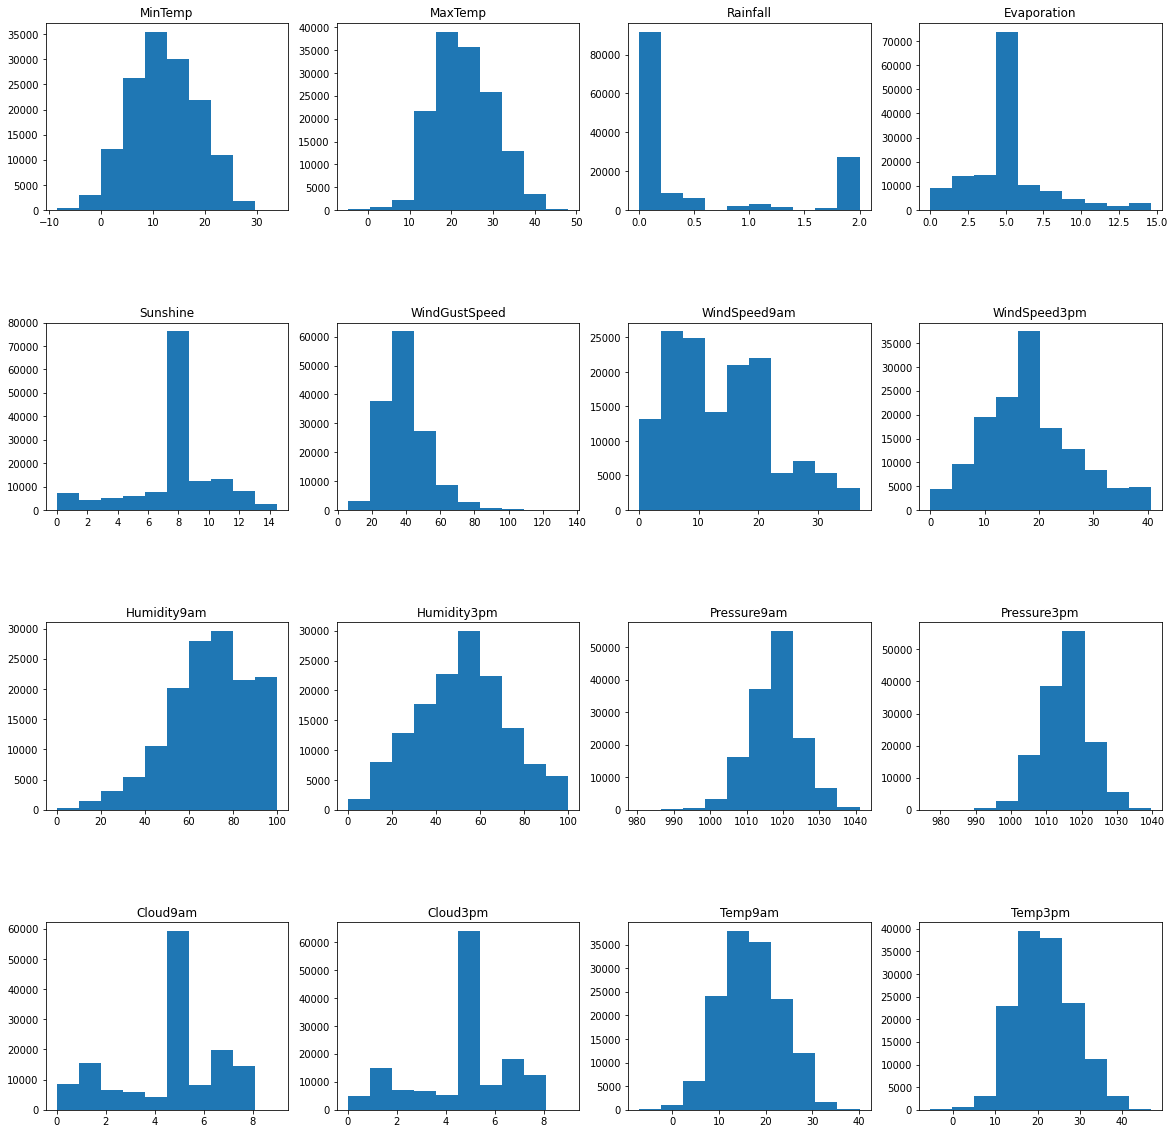

In [16]:
columnas = [columna for columna in df.columns if df[columna].dtype not in ["object","datetime64[ns]"] and columna not in ["Year","Month","Day"]]
cols = 4
fig, axs = plt.subplots(len(columnas)//cols, cols,figsize=(20,20) ) 
for i, columna in enumerate(columnas):
  axs[i//cols][i%cols].hist(df[columna])
  axs[i//cols][i%cols].set_title(columna)
plt.subplots_adjust(hspace=.6)

plt.show()

Podemos ver que las variables están más o menos distribuidas de forma uniforme a través de un rango fijo.

## Hot Encoding variables categóricas
---
Se realizará una transformación de todas las columnas con variables categóricas. Se transformarán de tipo nominal a tipo binario.

Se convierten los valores "yes" y "no" de la variable 'RainToday' en valores binarios

In [17]:
def binarizar(celda):
  if celda =="No":
    return 0
  else:
    return 1

df['RainToday'] = df['RainToday'].apply(binarizar)
df['RainTomorrow'] = df['RainTomorrow'].apply(binarizar)
df.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
0,Albury,13.4,22.9,0.6,4.8,8.5,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,0,0,2008,12,1
1,Albury,7.4,25.1,0.0,4.8,8.5,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,5.0,5.0,17.2,24.3,0,0,2008,12,2
2,Albury,12.9,25.7,0.0,4.8,8.5,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,5.0,2.0,21.0,23.2,0,0,2008,12,3
3,Albury,9.2,28.0,0.0,4.8,8.5,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,5.0,5.0,18.1,26.5,0,0,2008,12,4
4,Albury,17.5,32.3,1.0,4.8,8.5,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,2008,12,5


Se transforma las variables categóricas Location, WindGustDir, WindDir9am y WindDir3pm en variables binarias. Se va a renombrar la columna RainToday, de forma que quede en solo una columna.

In [18]:
numericas = [col for col in df.columns if df[col].dtypes in ["float64", "int64"] ]

df = pd.concat([df[numericas],
                     pd.get_dummies(df["Location"]), 
                     pd.get_dummies(df["WindGustDir"]),
                     pd.get_dummies(df["WindDir9am"]),
                     pd.get_dummies(df["WindDir3pm"])], axis=1)
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,...,S,SE,SSE,SSW,SW,W,WNW,WSW,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,13.4,22.9,0.6,4.8,8.5,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,0,0,2008,12,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,7.4,25.1,0.0,4.8,8.5,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,5.0,5.0,17.2,24.3,0,0,2008,12,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,12.9,25.7,0.0,4.8,8.5,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,5.0,2.0,21.0,23.2,0,0,2008,12,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,9.2,28.0,0.0,4.8,8.5,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,5.0,5.0,18.1,26.5,0,0,2008,12,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,17.5,32.3,1.0,4.8,8.5,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,2008,12,5,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


## Normalización de los datos
---
Dada la distribución de las variables los datos son normalizados a un mismo rango usando MixMaxScaler (Escalamiento lineal). De esta forma el modelo convergerá más rápido a una solución y esta será más precisa pues los rangos para todas las variables serán los mismos.

In [19]:
scaler = MinMaxScaler()

cols = list(df.columns)
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=cols)
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,...,S,SE,SSE,SSW,SW,W,WNW,WSW,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
count,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,...,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000,142193.000000
mean,0.487867,0.529780,0.240460,0.349188,0.554637,0.262947,0.375767,0.458215,0.688582,0.514957,0.614024,0.610440,0.516619,0.522518,0.510246,0.519692,0.221213,0.224181,0.575893,0.491140,0.490503,0.021731,0.021211,0.021175,0.021316,0.020592,0.021295,0.021337,0.022230,0.021014,0.024038,0.021014,0.020768,0.020697,0.022448,0.020957,0.022420,0.010964,0.021295,0.017125,...,0.062936,0.065467,0.063245,0.060552,0.061867,0.134395,0.056726,0.062598,0.063463,0.054398,0.053153,0.150542,0.052935,0.055896,0.055136,0.060144,0.059729,0.064434,0.063055,0.052380,0.057928,0.058090,0.050593,0.048125,0.058667,0.054321,0.058948,0.060952,0.057415,0.045319,0.054384,0.059553,0.067500,0.101559,0.064293,0.056332,0.064574,0.069701,0.060875,0.065608
std,0.150682,0.134397,0.394695,0.177969,0.191009,0.101865,0.231120,0.208575,0.189325,0.205322,0.111509,0.106909,0.254929,0.235417,0.136544,0.131886,0.415065,0.417043,0.254126,0.311501,0.293272,0.145804,0.144086,0.143969,0.144436,0.142014,0.144366,0.144506,0.147432,0.143430,0.153167,0.143430,0.142606,0.142369,0.148137,0.143242,0.148046,0.104134,0.144366,0.129736,...,0.242848,0.247350,0.243404,0.238507,0.240914,0.341077,0.231319,0.242239,0.243795,0.226802,0.224339,0.357603,0.223905,0.229721,0.228247,0.237754,0.236984,0.245525,0.243063,0.222792,0.233609,0.233914,0.219166,0.214031,0.235001,0.226650,0.235528,0.239244,0.232635,0.208003,0.226774,0.236657,0.250886,0.302069,0.245275,0.230562,0.245774,0.254643,0.239102,0.247597
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.379717,0.429112,0.000000,0.273973,0.565517,0.193798,0.189189,0.320988,0.570000,0.370000,0.545455,0.542400,0.333333,0.444444,0.411392,0.424184,0.000000,0.000000,0.4

# Aplicación de la regresión logística

## Preparación de los datos
---
Configuración de la variable objetivo y separación de los datos en conjunto de entrenamiento y de prueba.

In [20]:
df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day,Adelaide,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,...,S,SE,SSE,SSW,SW,W,WNW,WSW,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW,E,ENE,ESE,N,NE,NNE,NNW,NW,S,SE,SSE,SSW,SW,W,WNW,WSW
0,0.516509,0.523629,0.3,0.328767,0.586207,0.294574,0.540541,0.592593,0.71,0.22,0.449587,0.4800,0.888889,0.555556,0.508439,0.522073,0.0,0.0,0.1,1.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.375000,0.565217,0.0,0.328767,0.586207,0.294574,0.108108,0.543210,0.44,0.25,0.497521,0.4912,0.555556,0.555556,0.514768,0.570058,0.0,0.0,0.1,1.0,0.033333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.504717,0.576560,0.0,0.328767,0.586207,0.310078,0.513514,0.641975,0.38,0.30,0.447934,0.5056,0.555556,0.222222,0.594937,0.548944,0.0,0.0,0.1,1.0,0.066667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.417453,0.620038,0.0,0.328767,0.586207,0.139535,0.297297,0.222222,0.45,0.16,0.613223,0.5712,0.555556,0.555556,0.533755,0.612284,0.0,0.0,0.1,1.0,0.100000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.613208,0.701323,0.5,0.328767,0.586207,0.271318,0.189189,0.493827,0.82,0.33,0.500826,0.4624,0.777778,0.888889,0.527426,0.673704,0.0,0.0,0.1,1.0,0.133333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Primero separamos la variable objetivo

In [21]:
dforiginal = df
X = df.drop(['RainTomorrow'], axis=1)

y = df['RainTomorrow']

Dividimos el conjunto en grupo de entrenamiento y pruebas dejando el 80% de los datos en el conjunto de entrenamiento y el 20% restanto en el conjunto de prueba

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

X_train.shape, X_test.shape

((113754, 117), (28439, 117))

##Generación del modelo
---
Haciendo uso de regresión logisitca se genera un modelo que predice si al día siguiente va a llover. El solucionador a usar es liblinear pues es uno de los ideales para datasets pequeños como el del reto de acuerdo a la [documentación](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)


In [23]:
logreg = LogisticRegression(solver='liblinear', random_state=0)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

Se prueba el modelo con los conjuntos de entrenamiento y prueba. Como resultado se puede observar el puntaje de accuracy de los dos conjuntos.

In [24]:
print('Porcentaje de acierto conjunto de entrenamiento: {:.4f}'.format(logreg.score(X_train, y_train)))
print('Porcentaje de acierto conjunto de prueba: {:.4f}'.format(logreg.score(X_test, y_test)))

Porcentaje de acierto conjunto de entrenamiento: 0.8474
Porcentaje de acierto conjunto de prueba: 0.8495


## Matriz de confusión

In [25]:
y_prediction = logreg.predict(X_test)
cm = confusion_matrix(y_test, y_prediction)
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

print('Matriz de confusión:\n', cm)

print('\nTrue Positives(TP) = ', TP)
print('\nTrue Negatives(TN) = ', TN)
print('\nFalse Positives(FP) = ', FP)
print('\nFalse Negatives(FN) = ', FN)

Matriz de confusión:
 [[20870  1197]
 [ 3084  3288]]

True Positives(TP) =  20870

True Negatives(TN) =  3288

False Positives(FP) =  1197

False Negatives(FN) =  3084


In [26]:
accuracy = (TP + TN) / float(TP + TN + FP + FN)
precision = TP / float(TP + FP)
recall = TP / float(TP + FN)

print('Accuracy : {0:0.4f}'.format(accuracy))
print('Precision : {0:0.4f}'.format(precision))
print('Recall : {0:0.4f}'.format(recall))

Accuracy : 0.8495
Precision : 0.9458
Recall : 0.8713


Como se puede observar en la parte superior, este modelo tiene un desempeño muy alto. Nuestro modelo de todos los casos de prueba donde llovió, pudo predecir el 87,13% de los mismos. También de todas las veces que dijo que iba a llover el 94,58% de las veces efectivamente llovió. Por lo tanto es viable concluir que este modelo puede predecir de manera confiable si va a llover o no.


# Variable de mayor peso

In [27]:
pesos = list(zip(X_train.columns,logreg.coef_[0]))
pesos.sort(key=lambda x:x[1],reverse=True)
pesos

[('WindGustSpeed', 6.7035192265529675),
 ('Pressure9am', 6.329789569526772),
 ('Humidity3pm', 5.807637490780581),
 ('Temp3pm', 1.5660451553520367),
 ('Cloud3pm', 1.1498275341825557),
 ('Temp9am', 1.0474461096239875),
 ('MinTemp', 0.8349135583797545),
 ('Rainfall', 0.8327108621871046),
 ('Witchcliffe', 0.6014696865967072),
 ('Adelaide', 0.5578816617506213),
 ('Perth', 0.53771811351802),
 ('Penrith', 0.45746484011403077),
 ('Humidity9am', 0.4463759553474353),
 ('Albury', 0.42304506753162546),
 ('SalmonGums', 0.3835350520778987),
 ('PearceRAAF', 0.33350707681620523),
 ('PerthAirport', 0.3261017695046685),
 ('Tuggeranong', 0.31586057021199737),
 ('Brisbane', 0.3063802675068216),
 ('Cobar', 0.27506241723463776),
 ('Williamtown', 0.23371519210997174),
 ('BadgerysCreek', 0.18672514035049148),
 ('WaggaWagga', 0.18023721026581205),
 ('Year', 0.17599977580699938),
 ('Richmond', 0.15296477448260112),
 ('Evaporation', 0.14599793029856947),
 ('Bendigo', 0.12946157574187905),
 ('Walpole', 0.12629062

Las variables con valor absoluto más grande son Pressure3pm, WindGustSpeed, Humidity3pm y Pressure9am. A mayor presión a las 3 pm es más probable que no llueva, mientras que a mayor presión a las 9 am es más probable que llueva. También es más probable que llueva si la velocidad del viento y la humedad a las 3 son muy altas.

Por lo tanto se puede concluir que la velociadad del viento, la cual tiene el coeficiente positivo más grande, es la que más influye en que llueva al día siguiente. La variable que mide la presión a las 3 pm, la cuál tiene el coeficiente negativo más grande, es la que más influye en que no llueva al día siguiente. 

In [28]:
mas_pesada = pesos[0] if abs(pesos[0][1]) > abs(pesos[-1][1]) else pesos[-1]
mas_pesada

('Pressure3pm', -10.128668397101839)

Comparando los valores absolutos de ambas se puede evidenciar que Pressure3pm es la variable que más afecta el modelo e indica que si la presión es alta, es más probable que no llueva al día siguiente. Como se puede ver en los pesos de las variables Pressure9am es la segunda variable positiva con más peso, por tanto se podría concluir que la presión (al menos a las 9am y 3pm pues no hay datos de tomas en otras horas) es el factor con más efecto sobre el hecho de si lloverá al día siguiente o no. Donde una presión alta a las 9am puede implicar lluvias al día siguiente, mientras que una presión alta a las 3pm puede implicar que no habrá lluvia el día siguiente.